In [1]:
# Package Imports

import sklearn as sk
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from  matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.dummy import DummyRegressor

 Cite your source of data. (Remember to include your data as a comma separated value (CSV) file with
 your submission.


In [2]:
# Import dataset
df = pl.read_csv("project1_2008_all.csv")

# Read more csv's and concatenate (Optional)
df2 = pl.read_csv("project1_2009_all.csv")
df = pl.concat([df, df2])

# Adjust the dataset to have 110 features per row (instead of 55) by including the oppising team's metrics
#   This will help train more accurate models by training on matchup dependent data.

# Add goal_differential column to the dataframe
df = df.with_columns(
    (pl.col("goals_scored") - pl.col("goals_allowed")).alias("goal_differential")
)

# Convert 'col1' from float64 to int16 Future opitmization
# df = df.with_columns([
#     pl.col('goals_scored').cast(pl.Int16),  # Cast column from float64 to int16
# ])

df

match_id,team_id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,goals_scored,goals_allowed,goal_differential
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64
220071,362,48,34,16,25,29,16,13,44,51,50,60,20,105,35,22,16,72,68,221,19,45,29,19,15,34,43,54,16,23,23,14,18,20,20,24,15,12,42,37,96,23,16,32,39,35,15,18,20,20,15,16,16,61,66,65,2.0,1.0,1.0
220071,367,110,101,39,48,79,63,52,78,18,11,186,62,71,112,88,70,120,21,14,64,72,116,89,70,100,22,14,65,59,55,61,53,23,15,69,57,67,62,23,14,81,70,91,17,10,55,75,19,15,56,21,12,19,14,13,1.0,2.0,-1.0
220074,370,14,16,39,31,14,16,30,54,13,17,48,8,19,11,18,19,19,8,18,2,17,14,15,17,16,8,16,20,2,8,20,110,12,7,15,21,37,36,12,22,39,15,14,8,15,21,20,9,20,43,13,22,17,21,11,1.0,2.0,-1.0
220074,363,14,10,20,17,3,14,20,8,19,18,55,85,90,38,15,23,39,62,18,124,53,34,8,11,33,48,9,76,18,16,26,23,39,20,45,14,23,43,61,19,3,5,33,38,4,18,8,17,12,11,26,22,36,9,21,2.0,1.0,1.0
220070,359,36,46,38,44,20,33,37,11,41,25,56,47,56,32,31,44,11,50,39,75,161,72,91,102,16,162,133,76,32,57,56,12,71,59,74,106,132,15,163,123,30,54,7,70,50,55,10,86,74,15,98,75,11,13,125,2.0,0.0,2.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
272481,3611,5,7,8,13,25,14,27,42,6,8,25,27,17,21,26,16,27,8,17,35,21,25,32,24,35,14,25,23,28,35,24,37,15,26,24,27,26,36,10,19,49,38,50,15,23,32,45,12,23,51,10,19,15,30,14,4.0,0.0,4.0
285809,4398,1,3,3,1,1,1,1,1,1,1,1,2,3,1,1,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.0,1.0,-1.0
285809,4860,1,1,1,1,1,1,1,1,1,1,13,12,9,4,3,1,1,1,1,12,9,4,3,1,1,1,1,8,4,3,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,0.0,1.0


In [3]:
# Set random state
random_state = 999

# Filter out rows where 'goal_differential' is NaN or null
original_rows = df.shape[0]
df = df.filter(
    pl.col("goal_differential").is_not_null()
    & pl.col("goal_differential").is_finite()
)
rows_removed = original_rows - df.shape[0]
print(f"Rows removed from df after filtering: {rows_removed}")

# Filter the dataframe to only take certain rows based on team id (Optional)
#   This would be beneficial if we only want to train our model
#   on only teams from a certain league or set of leagues

df

Rows removed from df after filtering: 40


match_id,team_id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,goals_scored,goals_allowed,goal_differential
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64
220071,362,48,34,16,25,29,16,13,44,51,50,60,20,105,35,22,16,72,68,221,19,45,29,19,15,34,43,54,16,23,23,14,18,20,20,24,15,12,42,37,96,23,16,32,39,35,15,18,20,20,15,16,16,61,66,65,2.0,1.0,1.0
220071,367,110,101,39,48,79,63,52,78,18,11,186,62,71,112,88,70,120,21,14,64,72,116,89,70,100,22,14,65,59,55,61,53,23,15,69,57,67,62,23,14,81,70,91,17,10,55,75,19,15,56,21,12,19,14,13,1.0,2.0,-1.0
220074,370,14,16,39,31,14,16,30,54,13,17,48,8,19,11,18,19,19,8,18,2,17,14,15,17,16,8,16,20,2,8,20,110,12,7,15,21,37,36,12,22,39,15,14,8,15,21,20,9,20,43,13,22,17,21,11,1.0,2.0,-1.0
220074,363,14,10,20,17,3,14,20,8,19,18,55,85,90,38,15,23,39,62,18,124,53,34,8,11,33,48,9,76,18,16,26,23,39,20,45,14,23,43,61,19,3,5,33,38,4,18,8,17,12,11,26,22,36,9,21,2.0,1.0,1.0
220070,359,36,46,38,44,20,33,37,11,41,25,56,47,56,32,31,44,11,50,39,75,161,72,91,102,16,162,133,76,32,57,56,12,71,59,74,106,132,15,163,123,30,54,7,70,50,55,10,86,74,15,98,75,11,13,125,2.0,0.0,2.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
272481,3611,5,7,8,13,25,14,27,42,6,8,25,27,17,21,26,16,27,8,17,35,21,25,32,24,35,14,25,23,28,35,24,37,15,26,24,27,26,36,10,19,49,38,50,15,23,32,45,12,23,51,10,19,15,30,14,4.0,0.0,4.0
285809,4398,1,3,3,1,1,1,1,1,1,1,1,2,3,1,1,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.0,1.0,-1.0
285809,4860,1,1,1,1,1,1,1,1,1,1,13,12,9,4,3,1,1,1,1,12,9,4,3,1,1,1,1,8,4,3,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,0.0,1.0


Set aside 10% of your datapoints as a Test set. This will be used to compare the final performance of
 all the models we train. The remaining 90% of your data will be referred to as your Train/Validation
 dataset.


In [4]:
# Stratify the shuffling based on match_id
#   (This ensures we have no data leakage)
match_ids = df['match_id'].unique()

# Create a gss object to allocate 10% to test set
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=random_state)
# Split groups based on the criteria of retaining inputs for teams of the same match
train_holdout_idx, test_idx = next(gss.split(df, groups=df['match_id']))

# Split the df based on the indexes from the split
train_holdout_df = df[train_holdout_idx]
test_df = df[test_idx]

# Check percentages
print(f"Train/Holdout shape: {train_holdout_df.shape} ~{train_holdout_df.shape[0]/df.shape[0]}") # 90%
print(f"Test shape: {test_df.shape} ~{test_df.shape[0]/df.shape[0]}") # 10%

# Grab feature rows
X_columns = [f"feature_{i+1}" for i in range(55)]
y_column = ["goal_differential"]

# Set aside final test dataset
X_test, y_test = test_df[X_columns], test_df[y_column] # This is the final test dataset
# train holdout data
X_train_holdout, y_train_holdout = train_holdout_df[X_columns], train_holdout_df[y_column]

Train/Holdout shape: (50202, 60) ~0.9
Test shape: (5578, 60) ~0.1


Select a method to estimate the value of your error function on new data (Enew). We will be using Option 2: Holdout cross validation, and split the data as follows: 80% train / 20% validate.

In [5]:
gss2 = GroupShuffleSplit(n_splits=1, test_size=20/90, random_state=random_state)
train_idx, holdout_idx = next(gss2.split(train_holdout_df, groups=train_holdout_df['match_id']))
train_df = train_holdout_df[train_idx]
holdout_df = train_holdout_df[holdout_idx]

print(f"Train shape: {train_df.shape} ~{train_df.shape[0]/df.shape[0]}") # ~70% of total data
print(f"Holdout shape: {holdout_df.shape} ~{holdout_df.shape[0]/df.shape[0]}") # ~20% of total data

X_train, y_train = train_df[X_columns], train_df[y_column]
X_holdout, y_holdout = holdout_df[X_columns], holdout_df[y_column]

Train shape: (39046, 60) ~0.7
Holdout shape: (11156, 60) ~0.2


Choose your error function based on whether your problem involves regression (use mean-squared
 error) or classification (use 1 − accuracy).

 Similar to project 1, train a baseline classifier on your data. This can be a Dummy Classifier from
 scikit-learn, a simple kNN / Decision Tree, or something else. Be sure to clearly state what your
 baseline model is and how you created it.

In [6]:
# Create a DummyRegressor
dummy_regressor = DummyRegressor(strategy='mean')

# Fit the regressor
dummy_regressor.fit(X_train, y_train)

# Make predictions
y_pred_dummy = dummy_regressor.predict(X_holdout)

# Estimate of E_new
mse_dummy = mean_squared_error(y_holdout, y_pred_dummy)
print(f"Dummy Regressor MSE: {mse_dummy}")

baseline_model = Pipeline([
    ("dummy_regressor", DummyRegressor(strategy='mean'))
])
baseline_model.fit(X_train_holdout, y_train_holdout)

Dummy Regressor MSE: 3.0928648261025455


Pipeline(steps=[('dummy_regressor', DummyRegressor())])

Train a Linear regression model on your data. Do not use regularization (yet).

* Estimate Enew using your selected cross-validation method (kFold / holdout). Report this value.
* After cross-validation, train a final model on your Train/Validation dataset.

In [7]:
# Linear regression model
model_linear = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_regression", LinearRegression()),
])

# Cross Validation
model_linear.fit(X_train, y_train)
y_pred_linear = model_linear.predict(X_holdout)
mse_linear = mean_squared_error(y_holdout, y_pred_linear)
print(f"Linear Regression MSE: {mse_linear}")

best_linear_model = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_regression", LinearRegression()),
])
# Train model on final total dataset
best_linear_model.fit(X_train_holdout, y_train_holdout)


Linear Regression MSE: 3.088676797443711


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_regression', LinearRegression())])

Train a Linear regression model with polynomial features on your data. Do not use regularization (yet).

* Perform a hyperparameter sweep over different monomial combinations. Use your selected cross-validation method to estimate Enew for unseen data. Clearly state what monomial combinations you swept over.
* Plot the Enew estimates for the hyperparameters you swept over.
* Select the best hyperparameter combination and train a final model on your Train/Validation dataset.

In [8]:
# Create a Linear regression model with polynomial features of varying degrees
poly_error_dict = {}
for degree in [2]:
    model_poly = Pipeline([
        ("scaler", StandardScaler()),
        ("poly_features", PolynomialFeatures(
            degree=degree,
            )
        ),
        ("linear_regressor", LinearRegression()),
    ])
    model_poly.fit(X_train, y_train)
    y_pred_poly = model_poly.predict(X_holdout)
    mse_poly = mean_squared_error(y_holdout, y_pred_poly)
    poly_error_dict[degree] = mse_poly
    print(f"Polynomial Regression (degree {degree}) MSE: {mse_poly}")

# Train best model on final total dataset
best_poly_model = Pipeline([
        ("scaler", StandardScaler()),
        ("poly_features", PolynomialFeatures(
            degree=2,
            )
        ),
        ("linear_regressor", LinearRegression()),
    ])
best_poly_model.fit(X_train_holdout, y_train_holdout)


Polynomial Regression (degree 2) MSE: 3.274902330548702


Pipeline(steps=[('scaler', StandardScaler()),
                ('poly_features', PolynomialFeatures()),
                ('linear_regressor', LinearRegression())])

 For each of the regularization methods L1 (LASSO), L2, and Elastic-Net, train a Linear / Logistic
 regression model:

 * Perform a hyperparameter sweep over the coefficients for the penalty term.
 * Use your selected cross-validation method to estimate Enew for each hyperparameter combination. Make plots showing these estimated Enew values.

* Train a final model on the entire Train/Validation dataset using your best hyperparameter combination.

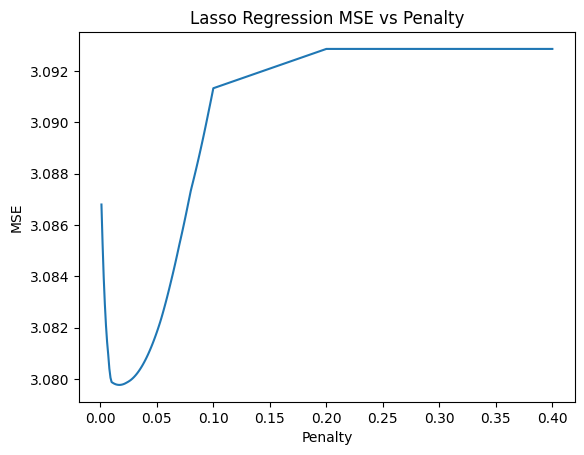

Best alpha: 0.017
Best MSE: 3.079762882633816


Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso_regressor', Lasso(alpha=0.017))])

In [9]:
# Sweep over penalty coefficients
penalties = np.linspace(0.001, 0.1, num=100)
penalties = penalties.tolist() + [.2,.4]
# print(penalties)
lass_error_dict = {}

for penalty in penalties:
  model_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso_regressor", Lasso(
        alpha=penalty,
        # fit_intercept=False,
      )),
  ])
  model_lasso.fit(X_train, y_train)
  y_pred_lasso = model_lasso.predict(X_holdout)
  mse_lasso = mean_squared_error(y_holdout, y_pred_lasso)
  lass_error_dict[penalty] = mse_lasso
  # print(f"Lasso Regression L1 (penalty {penalty}) MSE: {mse_lasso}")

# Graph the output
plt.plot(
    lass_error_dict.keys(),
    list(lass_error_dict.values())
)
plt.xlabel("Penalty")
plt.ylabel("MSE")
plt.title("Lasso Regression MSE vs Penalty")
plt.show()

# Save the best lasso model
best_alpha_lasso = min(lass_error_dict, key = lass_error_dict.get)
print(f"Best alpha: {best_alpha_lasso}")
print(f"Best MSE: {lass_error_dict[best_alpha_lasso]}")
best_lasso_model = Pipeline([
      ("scaler", StandardScaler()),
      ("lasso_regressor", Lasso(
          alpha = best_alpha_lasso
        )),
  ])
best_lasso_model.fit(X_train_holdout, y_train_holdout)

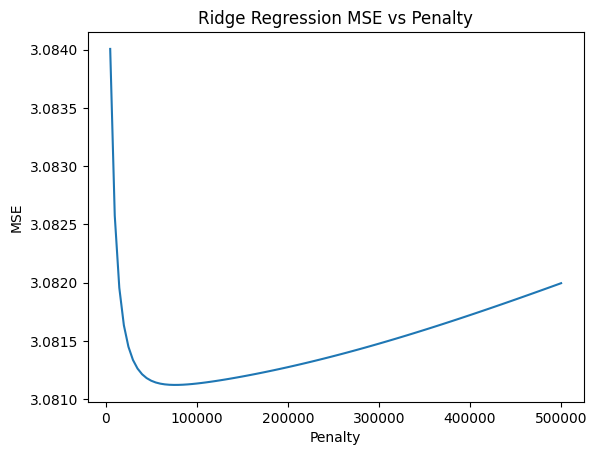

Best alpha: 75000.0
Best MSE: 3.0811227194231376


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=75000.0))])

In [10]:
# Ridge Regression
# Sweep over penalty coefficients
penalties = np.linspace(5000, 500000, num=100)
penalties
ridge_error_dict = {}

for penalty in penalties:
  model_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso_regressor", Ridge(
        alpha=penalty,
        # fit_intercept=False,
      )),
  ])
  model_ridge.fit(X_train, y_train)
  y_pred_ridge = model_ridge.predict(X_holdout)
  mse_ridge = mean_squared_error(y_holdout, y_pred_ridge)
  ridge_error_dict[penalty] = mse_ridge
  # print(f"Ridge Regression L2 (penalty {penalty}) MSE: {mse_ridge}")

# Plot the output
plt.plot(
    ridge_error_dict.keys(),
    list(ridge_error_dict.values())
)
plt.xlabel("Penalty")
plt.ylabel("MSE")
plt.title("Ridge Regression MSE vs Penalty")
plt.show()

# Save the best ridge model
best_alpha_ridge = min(ridge_error_dict, key = ridge_error_dict.get)
print(f"Best alpha: {best_alpha_ridge}")
print(f"Best MSE: {ridge_error_dict[best_alpha_ridge]}")
best_ridge_model = Pipeline([
      ("scaler", StandardScaler()),
      ("ridge_regressor", Ridge(
          alpha = best_alpha_ridge
        )),
  ])
best_ridge_model.fit(X_train_holdout, y_train_holdout)

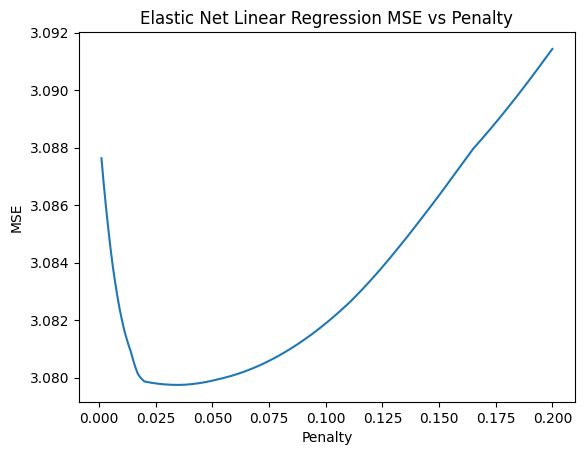

Best alpha: 0.035
Best MSE: 3.0797438270362947


Pipeline(steps=[('scaler', StandardScaler()),
                ('elastic_net_regressor', ElasticNet(alpha=0.035))])

In [11]:
# Elastic Net
penalties = np.linspace(0.001, 0.2, num=200)
penalties = penalties.tolist()
elastic_net_error_dict = {}

for penalty in penalties:
  model_elastic_net = Pipeline([
      ("scaler", StandardScaler()),
      ("elastic_net_regressor", ElasticNet(
          alpha=penalty,
          # fit_intercept=False,
        )),
  ])

  model_elastic_net.fit(X_train, y_train)
  y_pred_elastic_net = model_elastic_net.predict(X_holdout)
  mse_elastic_net = mean_squared_error(y_holdout, y_pred_elastic_net)
  elastic_net_error_dict[penalty] = mse_elastic_net
  # print(f"Elastic Net (penalty {penalty}) MSE: {mse_elastic_net}")

# Plot the output
plt.plot(
    elastic_net_error_dict.keys(),
    list(elastic_net_error_dict.values())
)
plt.xlabel("Penalty")
plt.ylabel("MSE")
plt.title("Elastic Net Linear Regression MSE vs Penalty")
plt.show()


# Save the best elasticnet model
best_alpha_elastic_net = min(elastic_net_error_dict, key = elastic_net_error_dict.get)
print(f"Best alpha: {best_alpha_elastic_net}")
print(f"Best MSE: {elastic_net_error_dict[best_alpha_elastic_net]}")
best_elastic_net_model = Pipeline([
      ("scaler", StandardScaler()),
      ("elastic_net_regressor", ElasticNet(
          alpha = best_alpha_elastic_net
        )),
  ])
best_elastic_net_model.fit(X_train_holdout, y_train_holdout)

 For each of the regularization methods L1 (LASSO), L2, and Elastic-Net, train a Linear / Logistic
 regression model with polynomial features:
 * Perform a hyperparameter sweep over both the coefficients for the penalty term and monomial combinations.
 * Use your selected cross-validation method to estimate Enew for each hyperparameter combination (coefficients and monomial combinations). Make plots showing these estimated Enew values.
 * Train a final model on the entire Train/Validation dataset using your best hyperparameter combination.

Lasso Regression (degree 2) L1 (penalty 0.05) MSE: 3.0796180836622766
Lasso Regression (degree 2) L1 (penalty 1.1555555555555554) MSE: 3.0928648261025455
Lasso Regression (degree 2) L1 (penalty 2.2611111111111106) MSE: 3.0928648261025455
Lasso Regression (degree 2) L1 (penalty 3.3666666666666663) MSE: 3.0928648261025455
Lasso Regression (degree 2) L1 (penalty 4.472222222222221) MSE: 3.0928648261025455
Lasso Regression (degree 2) L1 (penalty 5.577777777777777) MSE: 3.0928648261025455
Lasso Regression (degree 2) L1 (penalty 6.683333333333333) MSE: 3.0928648261025455
Lasso Regression (degree 2) L1 (penalty 7.788888888888888) MSE: 3.0928648261025455
Lasso Regression (degree 2) L1 (penalty 8.894444444444444) MSE: 3.0928648261025455
Lasso Regression (degree 2) L1 (penalty 10.0) MSE: 3.0928648261025455


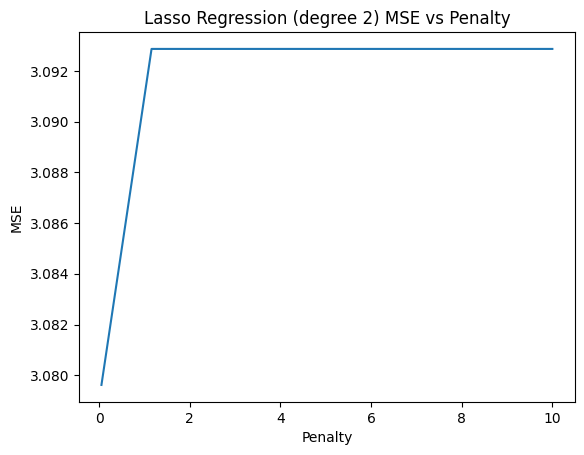

Best alpha: 0.05
Best MSE: 3.0796180836622766


Pipeline(steps=[('scaler', StandardScaler()),
                ('poly_features', PolynomialFeatures(include_bias=False)),
                ('lasso', Lasso(alpha=0.05))])

In [18]:
# Lasso (degree 2)
penalties = np.linspace(0.05,5,num=100)
# print (penalties)
lasso_poly_dict = {}
for penalty in penalties:
  model_lasso_poly = Pipeline([
    ("scaler", StandardScaler()),
    ("poly_features", PolynomialFeatures(
        degree=2,
        # include_bias=False,
        # interaction_only=True
    )),
    ("lasso", Lasso(
        alpha=penalty,
        # fit_intercept=False,
      )),
  ])
  model_lasso_poly.fit(X_train, y_train)
  y_pred_lasso_poly = model_lasso_poly.predict(X_holdout)
  mse_lasso_poly = mean_squared_error(y_holdout, y_pred_lasso_poly)
  lasso_poly_dict[penalty] = mse_lasso_poly
  print(f"Lasso Regression (degree 2) L1 (penalty {penalty}) MSE: {mse_lasso_poly}")

# Plot the output
plt.plot(
    lasso_poly_dict.keys(),
    list(lasso_poly_dict.values())
)
plt.xlabel("Penalty")
plt.ylabel("MSE")
plt.title("Lasso Regression (degree 2) MSE vs Penalty")
plt.show()

# Save the best lasso poly model
best_alpha_lass_poly = min(lasso_poly_dict, key = lasso_poly_dict.get)
print(f"Best alpha: {best_alpha_lass_poly}")
print(f"Best MSE: {lasso_poly_dict[best_alpha_lass_poly]}")
best_lasso_poly = Pipeline([
      ("scaler", StandardScaler()),
      ("poly_features", PolynomialFeatures(
          degree=2,
          include_bias=False,
          # interaction_only=True
        )),
      ("lasso", Lasso(
          alpha = best_alpha_lass_poly
        )),
  ])
best_lasso_poly.fit(X_train_holdout, y_train_holdout)



Ridge Regression (degree 2) L2 (penalty 800000.0) MSE: 3.0821134520988362
Ridge Regression (degree 2) L2 (penalty 801000.0) MSE: 3.0821131915465867
Ridge Regression (degree 2) L2 (penalty 802000.0) MSE: 3.082112934870882
Ridge Regression (degree 2) L2 (penalty 803000.0) MSE: 3.0821126820584857
Ridge Regression (degree 2) L2 (penalty 804000.0) MSE: 3.0821124330962193
Ridge Regression (degree 2) L2 (penalty 805000.0) MSE: 3.0821121879709574
Ridge Regression (degree 2) L2 (penalty 806000.0) MSE: 3.082111946669629
Ridge Regression (degree 2) L2 (penalty 807000.0) MSE: 3.0821117091792205
Ridge Regression (degree 2) L2 (penalty 808000.0) MSE: 3.0821114754867693
Ridge Regression (degree 2) L2 (penalty 809000.0) MSE: 3.082111245579367
Ridge Regression (degree 2) L2 (penalty 810000.0) MSE: 3.0821110194441603
Ridge Regression (degree 2) L2 (penalty 811000.0) MSE: 3.0821107970683483
Ridge Regression (degree 2) L2 (penalty 812000.0) MSE: 3.082110578439183
Ridge Regression (degree 2) L2 (penalty 81

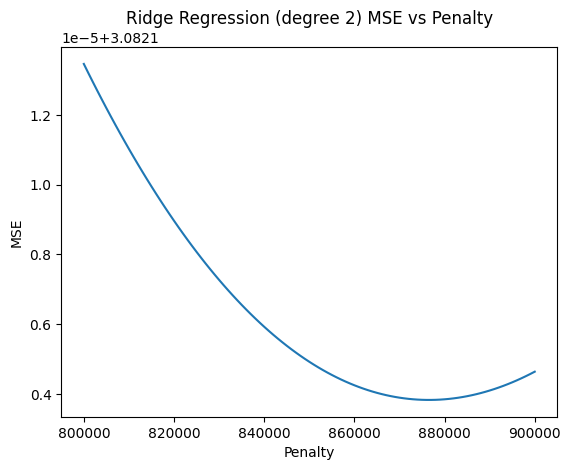

Best alpha: 877000.0
Best MSE: 3.082103833542391


Pipeline(steps=[('scaler', StandardScaler()),
                ('poly_features', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge(alpha=877000.0))])

In [27]:
# Ridge Poly model
penalties = np.linspace(800000, 900000, num=101)
ridge_poly_dict = {}
for penalty in penalties:
  model_ridge_poly = Pipeline([
    ("scaler", StandardScaler()),
    ("poly_features", PolynomialFeatures(
        degree=2,
        include_bias=False,
        interaction_only=True
    )),
    ("ridge", Ridge(
        alpha=penalty,
        # fit_intercept=False,
      )),
  ])
  model_ridge_poly.fit(X_train, y_train)
  y_pred_ridge_poly = model_ridge_poly.predict(X_holdout)
  mse_ridge_poly = mean_squared_error(y_holdout, y_pred_ridge_poly)
  ridge_poly_dict[penalty] = mse_ridge_poly
  print(f"Ridge Regression (degree 2) L2 (penalty {penalty}) MSE: {mse_ridge_poly}")

# Plot the output
plt.plot(
    ridge_poly_dict.keys(),
    list(ridge_poly_dict.values())
    )
plt.xlabel("Penalty")
plt.ylabel("MSE")
plt.title("Ridge Regression (degree 2) MSE vs Penalty")
plt.show()

# Save the best ridge poly model
best_alpha_ridge_poly = min(ridge_poly_dict, key = ridge_poly_dict.get)
print(f"Best alpha: {best_alpha_ridge_poly}")
print(f"Best MSE: {ridge_poly_dict[best_alpha_ridge_poly]}")
best_ridge_poly = Pipeline([
      ("scaler", StandardScaler()),
      ("poly_features", PolynomialFeatures(
          degree=2,
          include_bias=False,
          # interaction_only=True
        )),
      ("ridge", Ridge(
          alpha = best_alpha_ridge_poly
        )),
  ])
best_ridge_poly.fit(X_train_holdout, y_train_holdout)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.245e+04, tolerance: 1.216e+01
  model = cd_fast.enet_coordinate_descent(


Elastic Net (degree 2) (penalty 0.01) MSE: 3.090619820607004
Elastic Net (degree 2) (penalty 0.045) MSE: 3.0778445833720385
Elastic Net (degree 2) (penalty 0.07999999999999999) MSE: 3.0784146621238526
Elastic Net (degree 2) (penalty 0.11499999999999998) MSE: 3.0808880521042545
Elastic Net (degree 2) (penalty 0.15) MSE: 3.084284595563383
Elastic Net (degree 2) (penalty 0.185) MSE: 3.0862476744098224
Elastic Net (degree 2) (penalty 0.21999999999999997) MSE: 3.0865358723403604
Elastic Net (degree 2) (penalty 0.25499999999999995) MSE: 3.086890261071014
Elastic Net (degree 2) (penalty 0.29) MSE: 3.0873361572017344
Elastic Net (degree 2) (penalty 0.32499999999999996) MSE: 3.087774087477038
Elastic Net (degree 2) (penalty 0.36) MSE: 3.0882774085048776
Elastic Net (degree 2) (penalty 0.39499999999999996) MSE: 3.088852682135328
Elastic Net (degree 2) (penalty 0.42999999999999994) MSE: 3.089481769823366
Elastic Net (degree 2) (penalty 0.46499999999999997) MSE: 3.0900992797992006
Elastic Net (deg

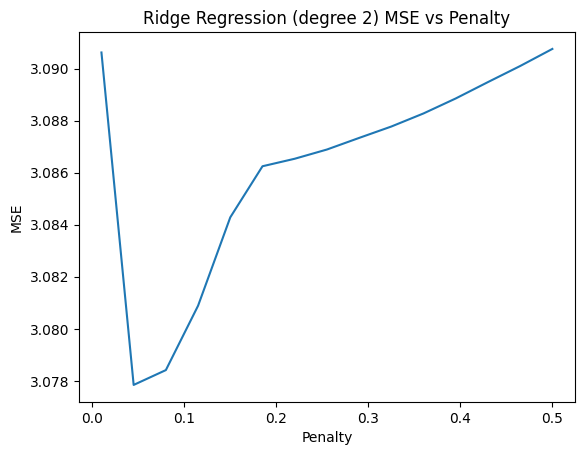

Best alpha: 0.045
Best MSE: 3.0778445833720385


Pipeline(steps=[('scaler', StandardScaler()),
                ('poly_features', PolynomialFeatures()),
                ('elastic_net', ElasticNet(alpha=0.045))])

In [34]:
# ElasticNet Poly Model
penalties = np.linspace(0.01, 0.5, num=15)
elastic_net_poly_dict = {}
for penalty in penalties:
  model_elastic_net_poly = Pipeline([
    ("scaler", StandardScaler()),
    ("poly_features", PolynomialFeatures(
        degree=2,
    )),
    ("elastic_net", ElasticNet(
        alpha=penalty,
        # fit_intercept=False,
      )),
  ])
  model_elastic_net_poly.fit(X_train, y_train)
  y_pred_elastic_net_poly = model_elastic_net_poly.predict(X_holdout)
  mse_elastic_net_poly = mean_squared_error(y_holdout, y_pred_elastic_net_poly)
  elastic_net_poly_dict[penalty] = mse_elastic_net_poly
  print(f"Elastic Net (degree 2) (penalty {penalty}) MSE: {mse_elastic_net_poly}")

# Plot the output
plt.plot(
    elastic_net_poly_dict.keys(),
    list(elastic_net_poly_dict.values())
    )
plt.xlabel("Penalty")
plt.ylabel("MSE")
plt.title("Ridge Regression (degree 2) MSE vs Penalty")
plt.show()

# Save the best model
best_alpha_elastic_net_poly = min(elastic_net_poly_dict, key = elastic_net_poly_dict.get)
print(f"Best alpha: {best_alpha_elastic_net_poly}")
print(f"Best MSE: {elastic_net_poly_dict[best_alpha_elastic_net_poly]}")
best_elastic_net_poly = Pipeline([
      ("scaler", StandardScaler()),
      ("poly_features", PolynomialFeatures(
          degree=2,
          # interaction_only=True
        )),
      ("elastic_net", ElasticNet(
          alpha = best_alpha_elastic_net_poly
        )),
  ])
best_elastic_net_poly.fit(X_train_holdout, y_train_holdout)


At this point you should have nine (9) trained Linear / Logistic regression final models:
 1. Baseline
 2. No regularization
 3. Polynomial Features, no regularization
 4. L1 (LASSO) regularization
 5. L2 regularization
 6. Elastic-Net regularization
 7. Polynomial features, L1 (LASSO) regularization
 8. Polynomial features, L2 regularization
 9. Polynomial features, Elastic-Net regularization
 Each of these models should have been trained on the entire Train/Validation dataset. The final experimental
 tasks are:
  * Test all nine (9) final models on the Test dataset.
  * Plot all final models’ scores on the same chart.

Baseline MSE: 3.061312298314808
Linear MSE: 3.0513796755896276
Polynomial MSE: 3.1702059623629935
Lasso MSE: 3.0506502075387663
Ridge MSE: 3.0492194419685723
Elastic Net MSE: 3.050638271685703
Lasso Poly MSE: 3.0485832703382516
Ridge Poly MSE: 3.0469370444265484
Elastic Net Poly MSE: 3.044816561716663


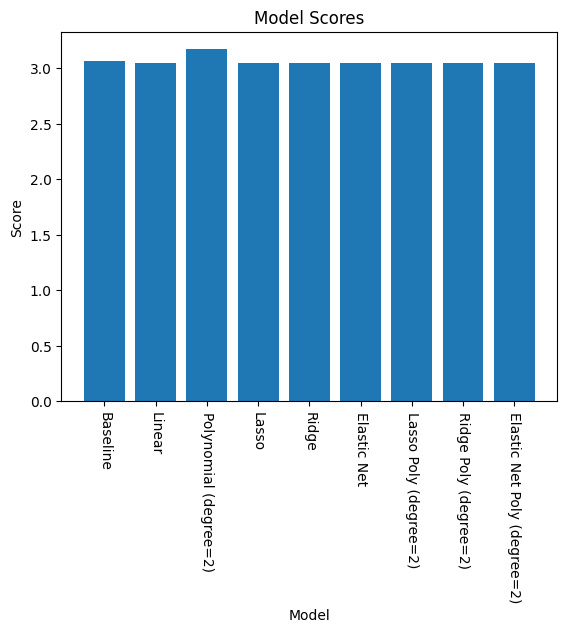

In [44]:
# Test all models on test data
baseline_mse = mean_squared_error(y_test, baseline_model.predict(X_test))
linear_mse = mean_squared_error(y_test, best_linear_model.predict(X_test))
poly_mse = mean_squared_error(y_test, best_poly_model.predict(X_test))
lasso_mse = mean_squared_error(y_test, best_lasso_model.predict(X_test))
ridge_mse = mean_squared_error(y_test, best_ridge_model.predict(X_test))
elastic_net_mse = mean_squared_error(y_test, best_elastic_net_model.predict(X_test))
lasso_poly_mse = mean_squared_error(y_test, best_lasso_poly.predict(X_test))
ridge_poly_mse = mean_squared_error(y_test, best_ridge_poly.predict(X_test))
elastic_net_poly_mse = mean_squared_error(y_test, best_elastic_net_poly.predict(X_test))

print(f"Baseline MSE: {baseline_mse}")
print(f"Linear MSE: {linear_mse}")
print(f"Polynomial MSE: {poly_mse}")
print(f"Lasso MSE: {lasso_mse}")
print(f"Ridge MSE: {ridge_mse}")
print(f"Elastic Net MSE: {elastic_net_mse}")
print(f"Lasso Poly MSE: {lasso_poly_mse}")
print(f"Ridge Poly MSE: {ridge_poly_mse}")
print(f"Elastic Net Poly MSE: {elastic_net_poly_mse}")

# Plot the scores
plt.bar(
    ["Baseline", "Linear", "Polynomial (degree=2)", "Lasso", "Ridge", "Elastic Net", "Lasso Poly (degree=2)", "Ridge Poly (degree=2)", "Elastic Net Poly (degree=2)"],
    [baseline_mse, linear_mse, poly_mse, lasso_mse, ridge_mse, elastic_net_mse, lasso_poly_mse, ridge_poly_mse, elastic_net_poly_mse]
)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Scores")
plt.xticks(rotation=-90)

plt.show()
